In [6]:
import pandas as pd
df = pd.read_csv("ratings.csv")
df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [7]:
df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [8]:
util_df = pd.pivot_table(data=df, values='rating', index='userId', columns='movieId')
# Заменяем значения Nan на 0
util_df = util_df.fillna(0)
util_df

In [11]:
from sklearn.model_selection import train_test_split

users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

df

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205
...,...,...,...,...
99999,670,7005,2.5,1065579370
100000,670,4771,4.0,1065149201
100001,670,1329,4.0,1070940363
100002,670,1331,2.5,1070979663


In [16]:
# Разбиваем датасет на тестовую и тренировочную выборку
x_train, x_test, y_train, y_test = train_test_split(df[['userId','movieId']], df[['rating']], test_size=0.20, shuffle=True)

In [18]:
# Создаем модель
from keras.layers import Dropout, Dense, Flatten, Activation,Input, Embedding
from keras.layers.merge import dot
from keras.models import Model

n_latent_factors = 64

n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())

user_input = Input(shape=(1,),name='user_input',dtype='int64')
user_embedding = Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
movie_input = Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding = Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
sim = dot([user_vec,movie_vec],name='Simalarity-Dot-Product', axes=1)
model = Model([user_input, movie_input], sim)
model.compile(loss='mse')

2022-05-31 13:47:23.770300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Обучение модели
History = model.fit([x_train.userId, x_train.movieId], y_train, 
                    batch_size=128, epochs = 50, validation_data = ([x_test.userId, x_test.movieId], y_test.rating), 
                    verbose = 1)

Epoch 1/50
626/626 [==============================] - 2s 2ms/step - loss: 13.4706 - val_loss: 12.6049
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 9.0602 - val_loss: 6.0729
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 4.4397 - val_loss: 3.7181
Epoch 4/50
626/626 [==============================] - 1s 2ms/step - loss: 2.8675 - val_loss: 2.7683
Epoch 5/50
626/626 [==============================] - 1s 2ms/step - loss: 2.1592 - val_loss: 2.2916
Epoch 6/50
626/626 [==============================] - 1s 2ms/step - loss: 1.7697 - val_loss: 2.0172
Epoch 7/50
626/626 [==============================] - 1s 2ms/step - loss: 1.5207 - val_loss: 1.8333
Epoch 8/50
626/626 [==============================] - 1s 2ms/step - loss: 1.3472 - val_loss: 1.7149
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 1.2202 - val_loss: 1.6219
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 1.1204 - val_loss: 1.55

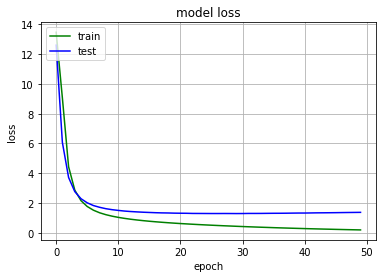

In [20]:
# Для оценки производительности модели результаты ее обучения можно отобразить в виде графика
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

import matplotlib.pyplot as plt

plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()